In [1]:
import warnings
warnings.filterwarnings('ignore')

In [138]:
from pathlib import Path
import requests

from datetime import datetime

import itertools


import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from talib import RSI, BBANDS, MACD

from pykalman import KalmanFilter
import pywt


pd.set_option('display.expand_frame_repr', False)

## Set Data Store path

In [3]:
DATA_STORE = Path('assets.h5')

## Quandl Wiki Prices
1. Follow the instructions to create a free [NASDAQ account](https://data.nasdaq.com/sign-up)
2. [Download](https://data.nasdaq.com/tables/WIKIP/WIKI-PRICES/export) the entire WIKI/PRICES data
3. Extract the .zip file,
4. Move to this directory and rename to wiki_prices.csv
5. Store data in fast HDF format for fast execution

This need to be run just once to store the data in HDF format

In [12]:
# only run this once to store data in HDF format
df = (pd.read_csv('wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

In [13]:
df.tail()

open   high    low  close      volume  ex-dividend  split_ratio  adj_open  adj_high  adj_low  adj_close  adj_volume
date       ticker                                                                                                                      
2018-03-27 ZIXI     4.43   4.45   4.35   4.39    207304.0          0.0          1.0      4.43      4.45     4.35       4.39    207304.0
           ZNGA     3.85   3.85   3.68   3.70  11026010.0          0.0          1.0      3.85      3.85     3.68       3.70  11026010.0
           ZOES    15.13  15.24  14.75  14.88    261242.0          0.0          1.0     15.13     15.24    14.75      14.88    261242.0
           ZTS     84.08  84.45  81.21  81.86   2676191.0          0.0          1.0     84.08     84.45    81.21      81.86   2676191.0
           ZUMZ    24.65  24.65  23.35  23.60    403884.0          0.0          1.0     24.65     24.65    23.35      23.60    403884.0

In [9]:
print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB
None


In [10]:
df = pd.read_csv('wiki_stocks.csv')
# no longer needed
# df = pd.concat([df.loc[:, 'code'].str.strip(),
#                 df.loc[:, 'name'].str.split('(', expand=True)[0].str.strip().to_frame('name')], axis=1)

print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/stocks', df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    3199 non-null   object
 1   name    3199 non-null   object
dtypes: object(2)
memory usage: 50.1+ KB
None


In [19]:
df = pd.read_csv('us_equities_meta_data.csv')
df.info()
with pd.HDFStore(DATA_STORE) as store:
    store.put('us_equities/stocks', df.set_index('ticker'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6834 entries, 0 to 6833
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     6834 non-null   object 
 1   name       6834 non-null   object 
 2   lastsale   6718 non-null   float64
 3   marketcap  5766 non-null   float64
 4   ipoyear    3038 non-null   float64
 5   sector     5288 non-null   object 
 6   industry   5288 non-null   object 
dtypes: float64(3), object(4)
memory usage: 373.9+ KB


## S&P 500 Prices

The following code downloads historical S&P 500 prices from FRED (only last 10 years of daily data is freely available)

In [109]:
df = web.DataReader(name='SP500', data_source='fred', start=2009).squeeze().to_frame('close')
print(df.info())
with pd.HDFStore(DATA_STORE) as store:
    store.put('sp500/fred', df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2012-11-02 to 2022-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2517 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB
None


# Feature Engineering

## Load the data
We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

In [14]:
START = 2000
END = 2018

In [17]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [20]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [21]:
prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN


In [23]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [24]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [27]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [28]:
shared = prices.columns.intersection(stocks.index)

In [31]:
shared

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZEN', 'ZEUS', 'ZGNX', 'ZION', 'ZIOP', 'ZIXI', 'ZNGA', 'ZOES', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=2412)

In [29]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [30]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [32]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [33]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [35]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


In [36]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.9+ MB


In [39]:
data.head()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993


## Drop stocks with less than 10 yrs of returns

In [40]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [41]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


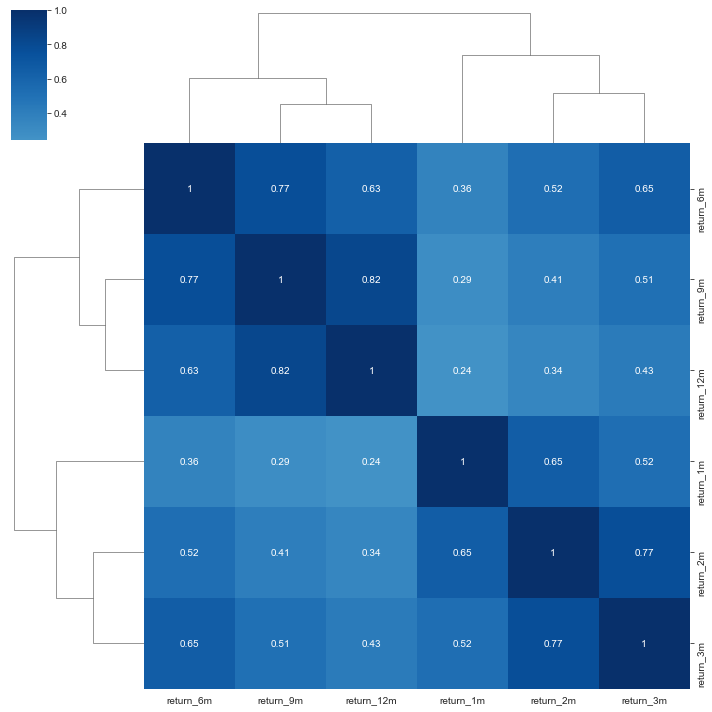

In [42]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

In [43]:
data.index.get_level_values('ticker').nunique()

1838

## Rolling Factor Betas

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library .

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [44]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2000-01-31 to 2022-09-30
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  273 non-null    float64
 1   SMB     273 non-null    float64
 2   HML     273 non-null    float64
 3   RMW     273 non-null    float64
 4   CMA     273 non-null    float64
dtypes: float64(5)
memory usage: 12.8 KB


In [46]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [55]:
factor_data.head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0550 -0.0509 -0.0470 -0.0500  -0.003653
       2001-02-28 -0.1005  0.0282  0.1248  0.0911  0.0905  -0.329564
       2001-03-31 -0.0726  0.0233  0.0642  0.0336  0.0391  -0.146389
       2001-04-30  0.0794 -0.0086 -0.0468 -0.0307 -0.0319   0.269444
       2001-05-31  0.0072  0.0359  0.0338  0.0026  0.0188  -0.140220

In [47]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [54]:
betas.tail()

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
ZUMZ   2017-11-30 -0.766557  1.325263  1.322945  3.462953  1.026065
       2017-12-31 -0.958808  1.658193  1.523229  3.646938  0.371988
       2018-01-31  0.075697  1.161659  1.317316  2.983589  0.661756
       2018-02-28  0.330981  1.026937  1.341743  2.721455  0.697090
       2018-03-31  0.230573  1.659271  1.157683  2.950366  0.573229

In [48]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.978889,0.626565,0.123485,-0.062155,0.016914,1.486397
std,0.917591,1.254674,1.602562,1.907076,2.155889,3.305914
min,-9.825518,-10.420754,-15.215922,-23.005713,-18.423557,-33.251810
25%,0.463566,-0.119243,-0.706422,-0.973602,-1.071335,0.000000
50%,0.928593,0.541534,0.096089,0.038055,0.040684,1.214759
75%,1.444069,1.303951,0.947859,0.949507,1.135144,3.146852
max,10.858294,10.459489,15.094963,16.977443,16.657684,34.097389


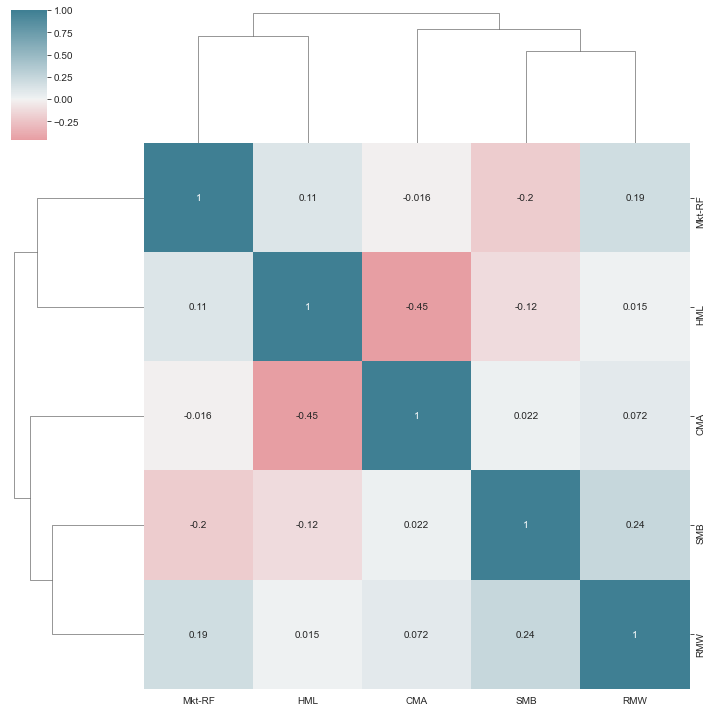

In [49]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [57]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


In [58]:
data.tail()

return_1m  return_2m  return_3m  return_6m  return_9m  return_12m    Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                                                                                           
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   -0.010687 -0.768395  0.998015  1.349890  2.950637  1.315143
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   -0.003996 -0.766557  1.325263  1.322945  3.462953  1.026065
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237    0.002864 -0.958808  1.658193  1.523229  3.646938  0.371988
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   -0.002905  0.075697  1.161659  1.317316  2.983589  0.661756
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606    0.021422  0.330981  1.026937  1.341743  2.721455  0.697090

### Impute mean for missing factor betas

In [59]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [60]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [61]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [62]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [63]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [64]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3
ticker date                                                                                                                     
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966  -0.105747      -0.146389      -0.329564      -0.003653
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721  -0.023317       0.269444      -0.146389      -0.329564
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   0.018842      -0.140220       0.269444      -0.146389
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414  -0.098192      -0.031008      -0.140220       0.269444
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014  -0.075527      -0.119692      -0.031008      -0.140220
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364  -0.155847      -0.073750      -0.119692      -0.031008
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279  -0.080114      -0.262264      -0.073750      -0.119692
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   0.009593       0.139130      -0.262264      -0.073750
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   0.134010       0.224517       0.139130      -0.262264
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   0.108697       0.045471       0.224517       0.139130

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [66]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [67]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [68]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [69]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [70]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [71]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Store data

In [75]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: assets.h5
/engineered_features            frame        (shape->[358914,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/us_equities/stocks             frame        (shape->[6834,6])     


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [76]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64


## Generate Technical Alpha Factors

In [88]:
## generating for AAPL - need to do for all
with pd.HDFStore(DATA_STORE) as store:
    data = (store['quandl/wiki/prices']
            .loc[idx['2007':'2018', 'AAPL'],
                 ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]
            .unstack('ticker')
            .swaplevel(axis=1)
            .loc[:, 'AAPL']
            .rename(columns=lambda x: x.replace('adj_', '')))

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2826 entries, 2007-01-03 to 2018-03-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2826 non-null   float64
 1   high    2826 non-null   float64
 2   low     2826 non-null   float64
 3   close   2826 non-null   float64
 4   volume  2826 non-null   float64
dtypes: float64(5)
memory usage: 132.5 KB


## Compute Bollinger Bands

In [90]:
up, mid, low = BBANDS(data.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

## Compute Relative Strength Index

In [91]:
rsi = RSI(data.close, timeperiod=14)

## Moving Average Convergence/Divergence

The MACD computes the difference between two Exponential Moving Averages (EMA), one longer- and one shorter-term.

The ta-lib MACD Indicator implementation has four inputs:
- the close price
- `fastperiod`: the short-term EMA period
- `slowperiod`: the long-term EMA period
- `signalperiod`: the period for the EMA of the MACD itself

It has three outputs:
- `macd` is the difference between the fast EMA and slow EMA.
- `macdsignal` is the EMA of the MACD value with period `signalperiod`
- `macdhist` computes the difference between `macd` and `macdsignal`

In [92]:
macd, macdsignal, macdhist = MACD(data.close, fastperiod=12, slowperiod=26, signalperiod=9)

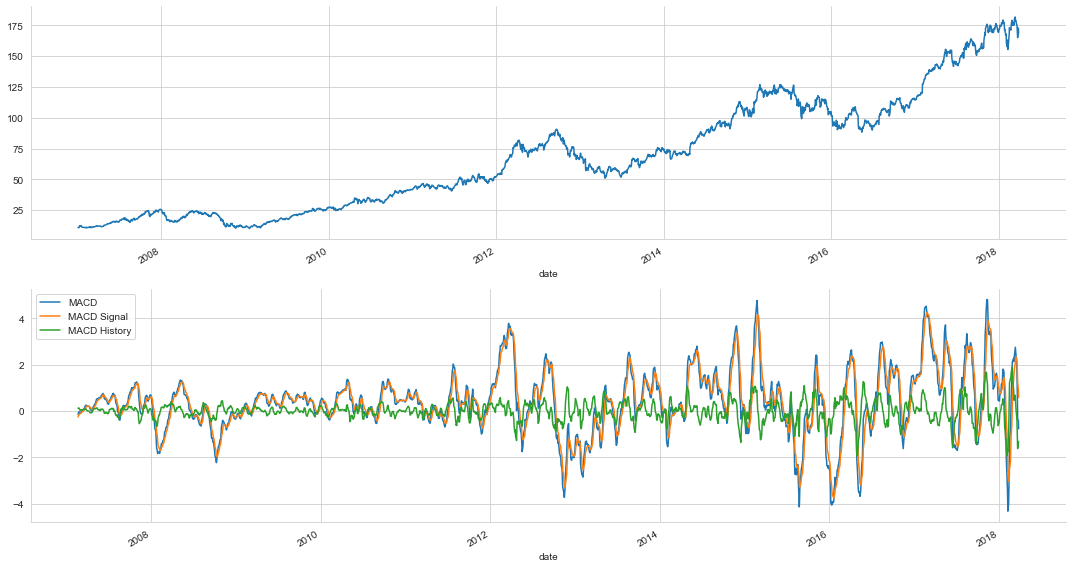

In [93]:
macd_data = pd.DataFrame({'AAPL': data.close, 'MACD': macd, 'MACD Signal': macdsignal, 'MACD History': macdhist})

fig, axes= plt.subplots(nrows=2, figsize=(15, 8))
macd_data.AAPL.plot(ax=axes[0])
macd_data.drop('AAPL', axis=1).plot(ax=axes[1])
fig.tight_layout()
sns.despine();

## Plot Result

In [94]:
data = pd.DataFrame({'AAPL': data.close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi, 'MACD': macd})

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2826 entries, 2007-01-03 to 2018-03-27
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     2826 non-null   float64
 1   BB Up    2806 non-null   float64
 2   BB Mid   2806 non-null   float64
 3   BB down  2806 non-null   float64
 4   RSI      2812 non-null   float64
 5   MACD     2793 non-null   float64
dtypes: float64(6)
memory usage: 154.5 KB


In [100]:
data.tail()

,AAPL,BB Up,BB Mid,BB down,RSI,MACD
date,,,,,,
2018-03-21,171.270,182.091745,176.665000,171.238255,42.302794,1.129731
2018-03-22,168.845,182.482734,176.559048,170.635361,38.343555,0.467060
2018-03-23,164.940,183.763106,176.194286,168.625465,32.989187,-0.368959
2018-03-26,172.770,183.767010,176.061667,168.356323,48.514111,-0.395139
2018-03-27,168.340,183.807340,175.555476,167.303612,42.512984,-0.764539


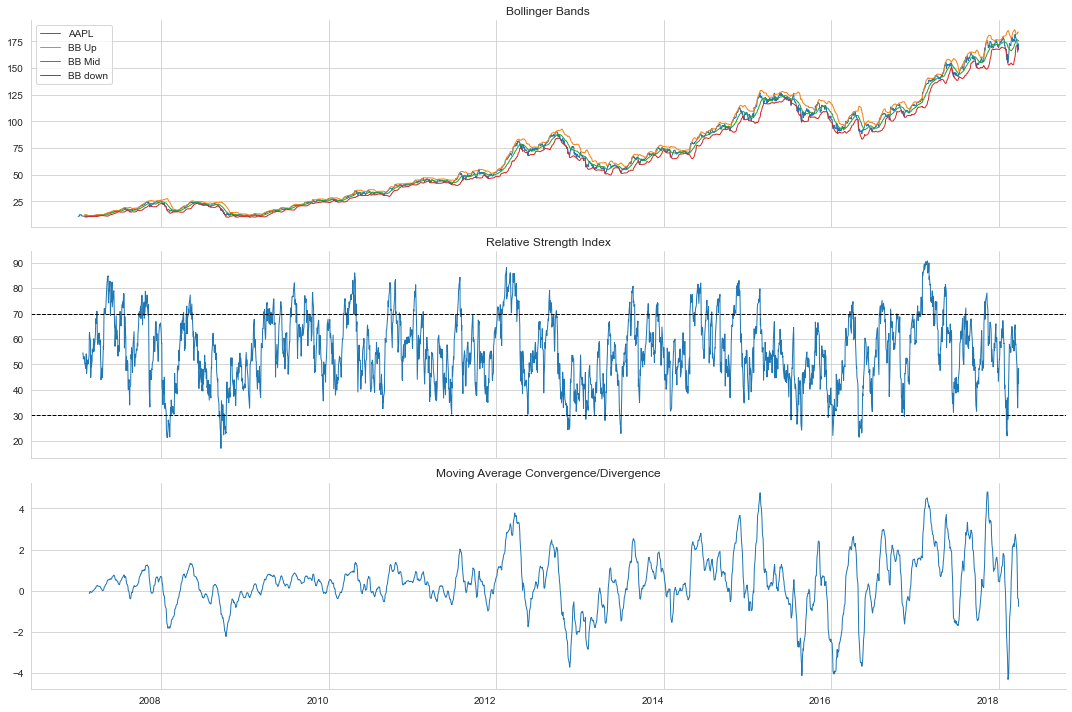

In [95]:
fig, axes= plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
data.drop(['RSI', 'MACD'], axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')
data.MACD.plot(ax=axes[2], lw=1, title='Moving Average Convergence/Divergence', rot=0)
axes[2].set_xlabel('')
fig.tight_layout()
sns.despine();

In [112]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('technical_engineered_features', data)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: assets.h5
/engineered_features                      frame        (shape->[358914,33])  
/quandl/wiki/prices                       frame        (shape->[15389314,12])
/quandl/wiki/stocks                       frame        (shape->[1,2])        
/sp500/fred                               frame        (shape->[2608,1])     
/technical_engineered_features            frame        (shape->[2826,6])     
/us_equities/stocks                       frame        (shape->[6834,6])     


# Denoising alpha factors with the Kalman filter

In [115]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/fred']

In [117]:
sp500.tail()

,close
DATE,
2022-10-26,3830.60
2022-10-27,3807.30
2022-10-28,3901.06
2022-10-31,3871.98
2022-11-01,3856.10


## Kalman Filter 

### Configuration

In [118]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

### Estimate the hidden state

In [119]:
state_means, _ = kf.filter(sp500)

### Compare with moving average

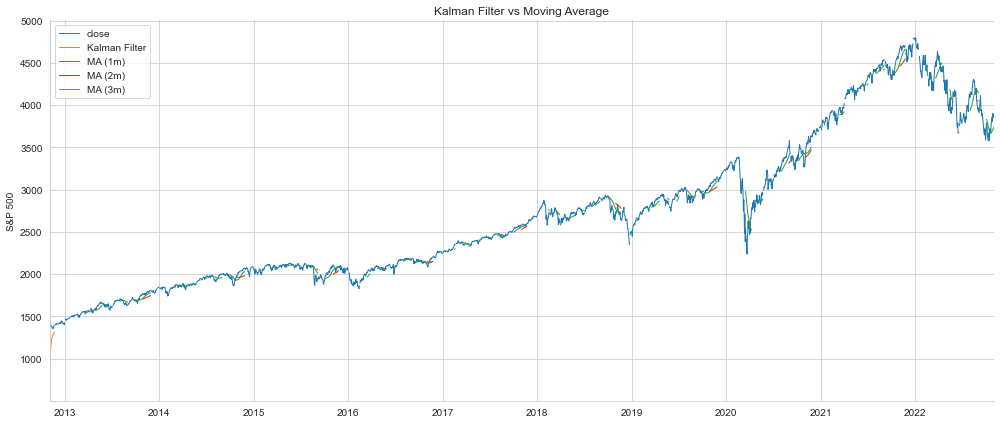

In [134]:
sp500_smoothed = sp500
sp500_smoothed['Kalman Filter'] = state_means
for months in [1,2,3]:
    sp500_smoothed[f'MA ({months}m)'] = sp500['close'].rolling(window=months*21).mean()

ax = sp500_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14,6), lw=1, rot=0)
ax.set_xlabel('')
ax.set_ylabel('S&P 500')
plt.tight_layout()
sns.despine()

In [ ]:
#we may consider  particle filter is an alternative approach that uses sampling-based Monte Carlo
#approaches to estimate non-normal distributions.

## Preprocess noisy signals using wavelets 

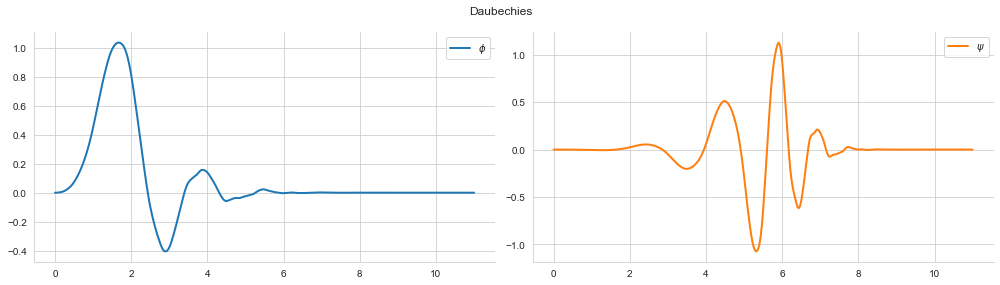

In [136]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=5)
df = pd.DataFrame({'$\phi$': phi, '$\psi$': psi}, index=x)
df.plot(title='Daubechies', subplots=True, layout=(1, 2), figsize=(14, 4), lw=2, rot=0)
plt.tight_layout()
sns.despine();

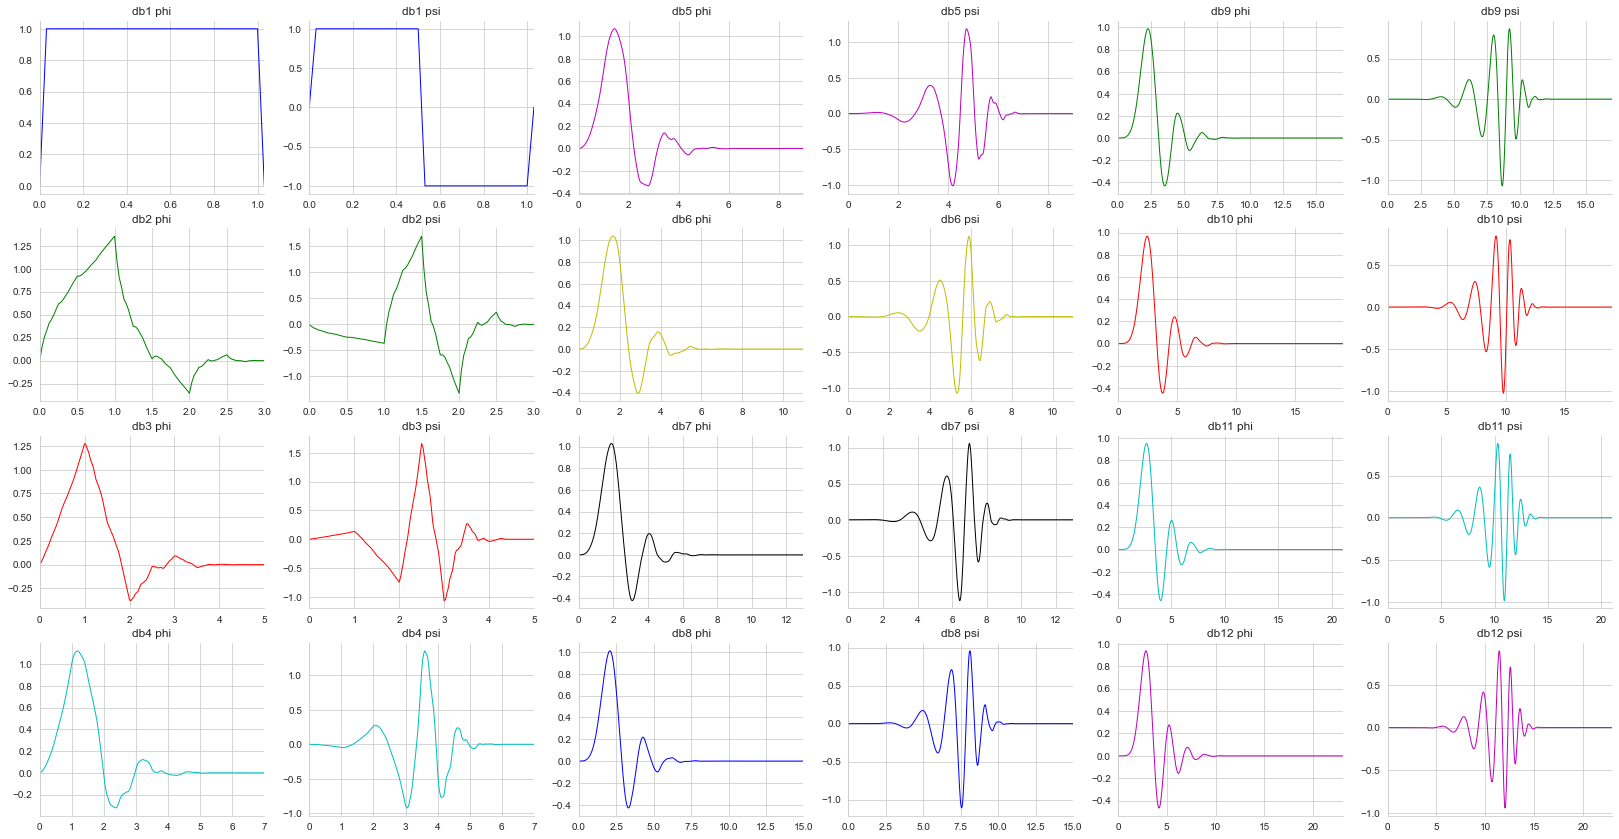

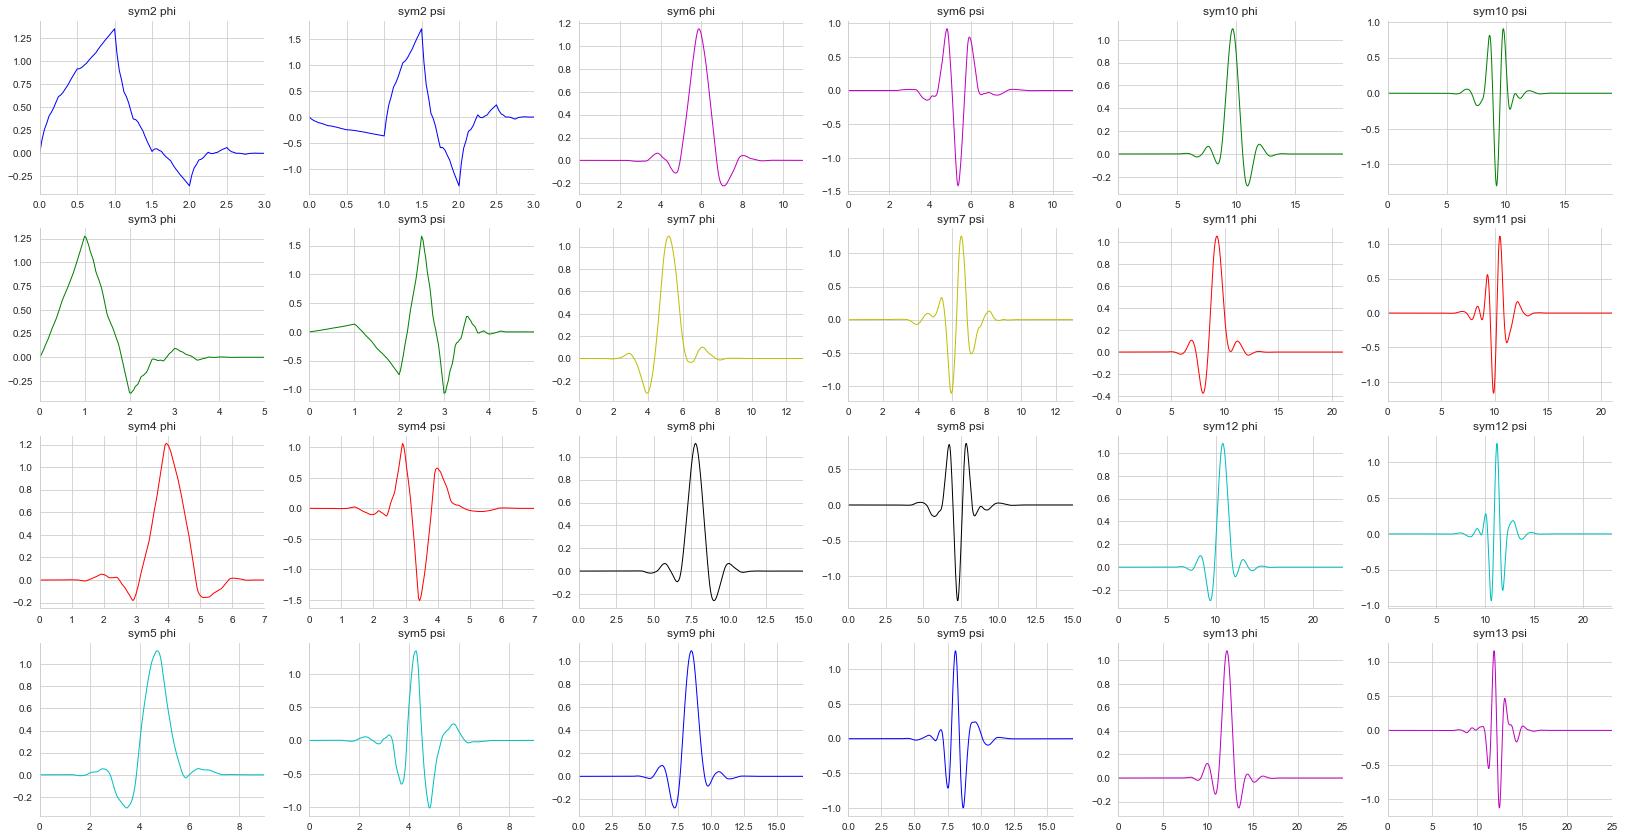

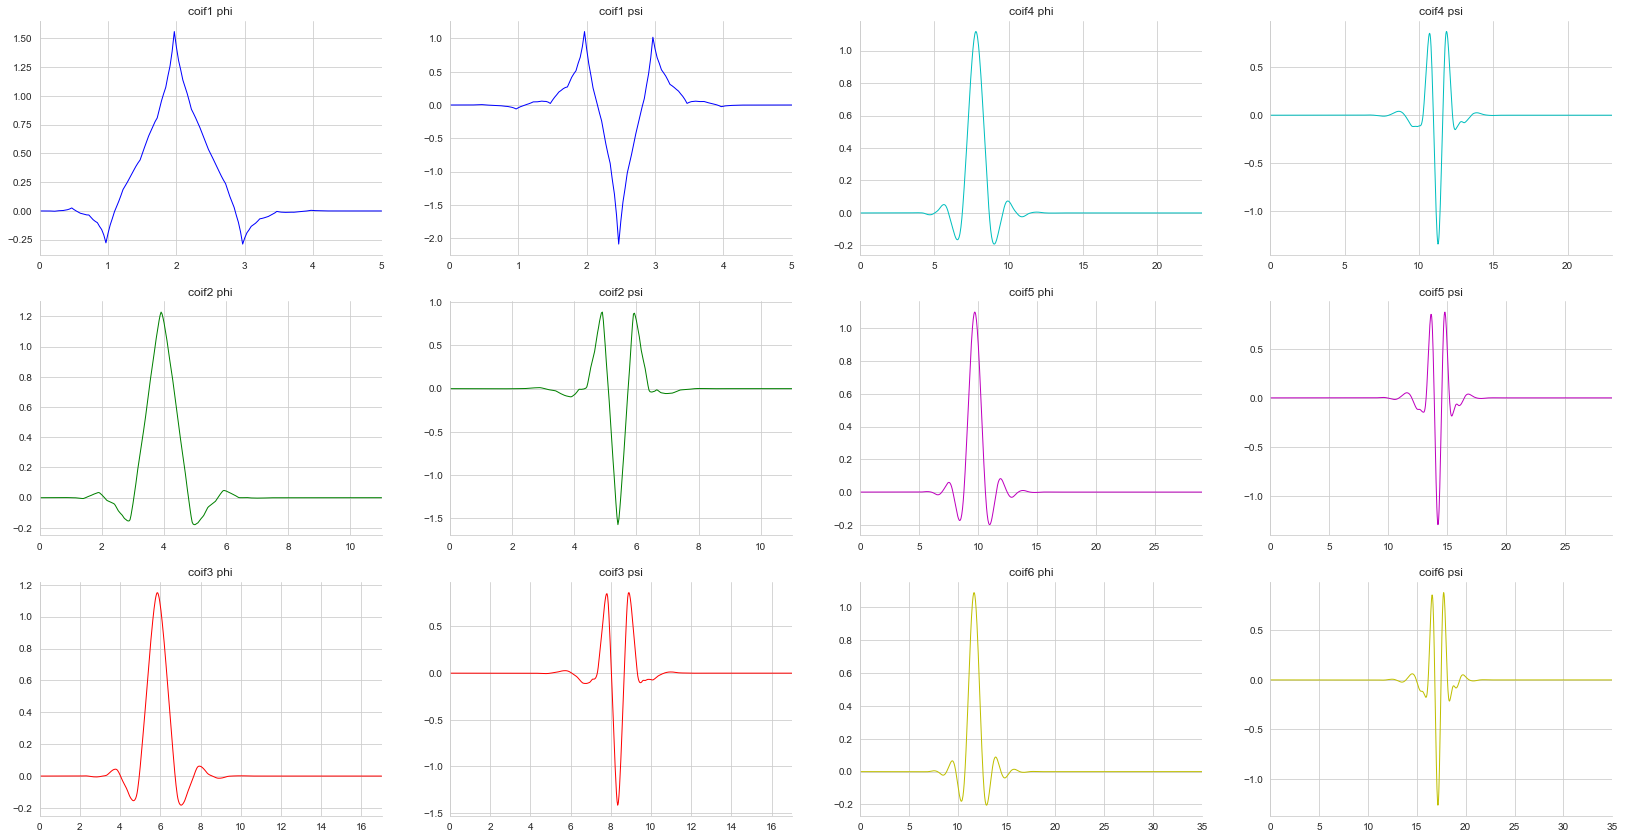

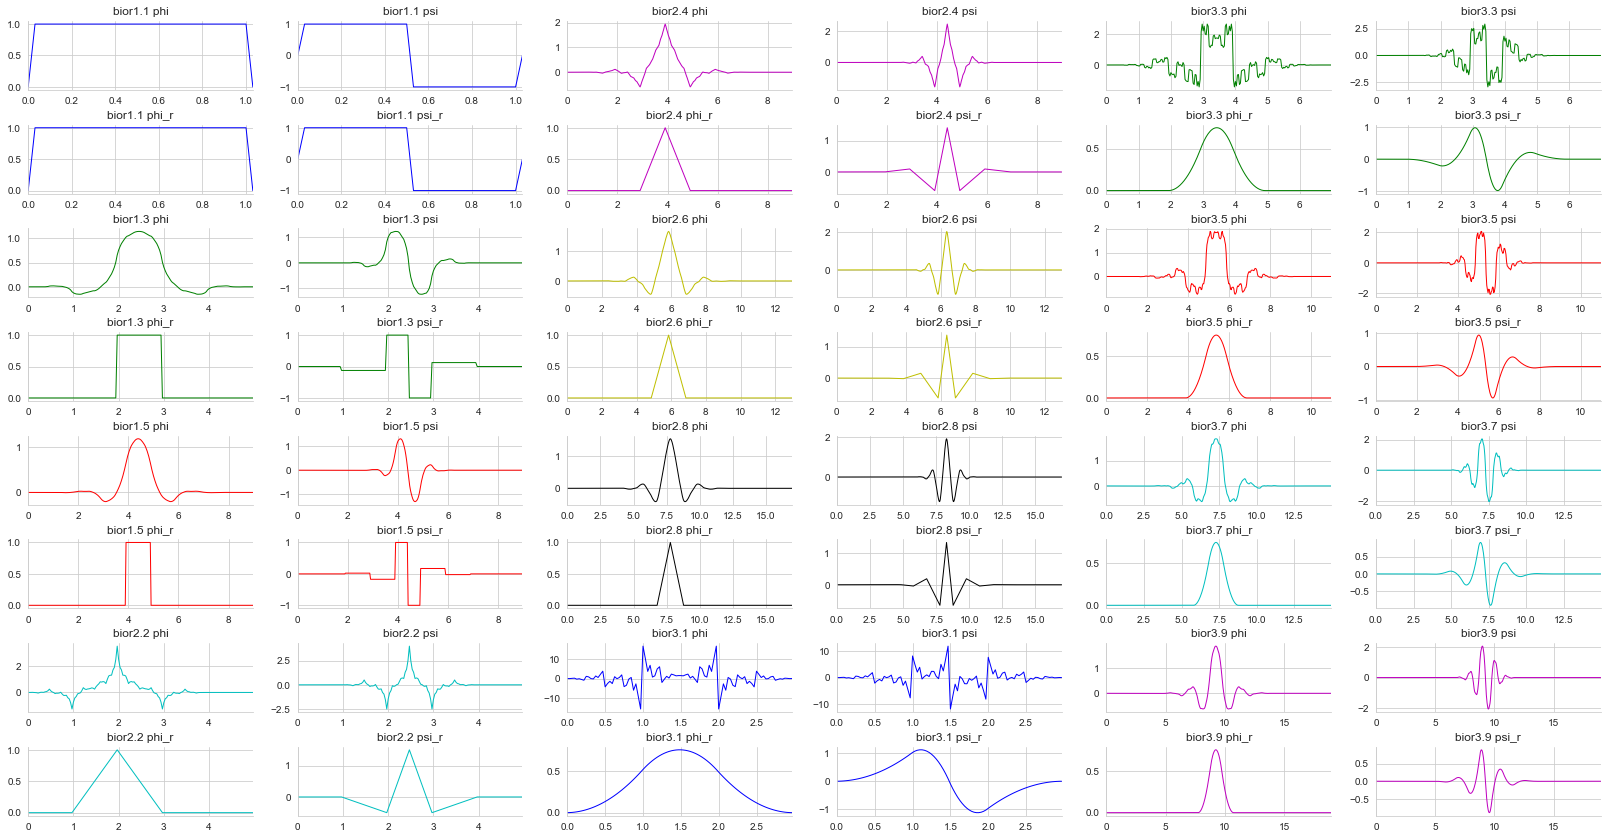

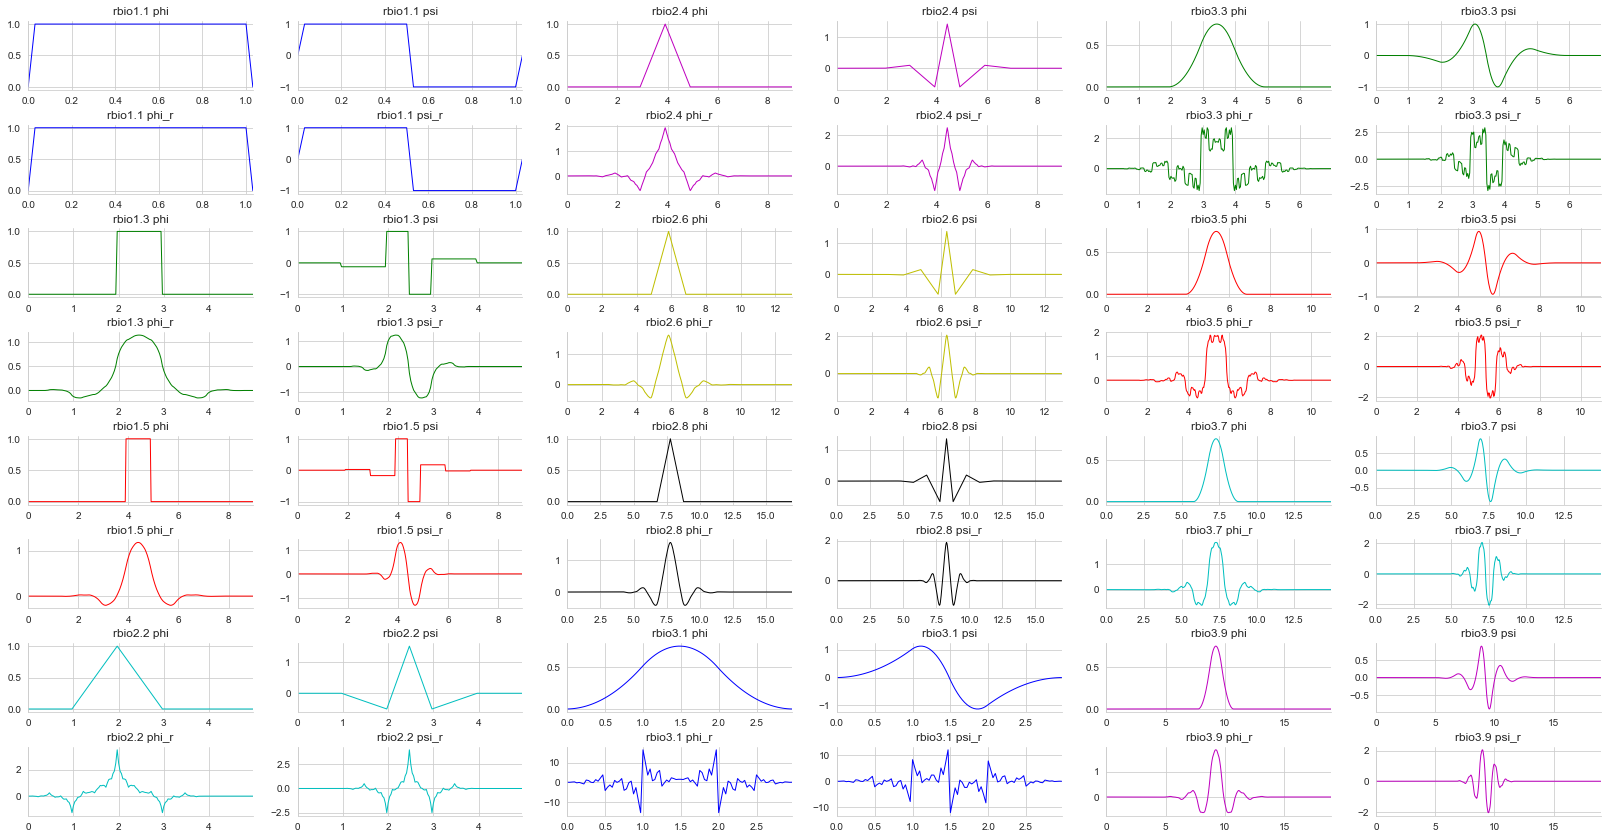

In [139]:
plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))
    sns.despine()

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))
    sns.despine()

plt.show()

### Available Wavelet Families

In [140]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

### Smoothing the S&P 500

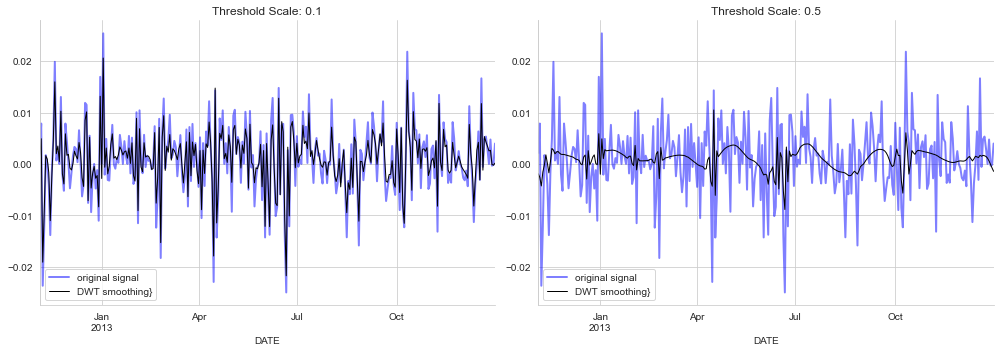

In [144]:
signal = (pd.read_hdf(DATA_STORE, 'sp500/fred')
          .loc['2012': '2013']
          .close.pct_change()
          .dropna())

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

wavelet = "db6"
for i, scale in enumerate([.1, .5]):
    
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2, 
                 title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])
    axes[i].legend()
fig.tight_layout()
sns.despine();

In [ ]:
# need to analyse more wavelet families